In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.metrics import mean_squared_error
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
import statsmodels.formula.api as sm
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn import metrics
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

In [95]:
qbs = pd.read_csv('C://Users//Michael//Desktop//Springboard//Capstone2//csvFiles//qbModelData.csv',index_col=0)

In [96]:
# Find index for fantasypoints (target variable) so we can break data into train/test easier
cols = list(qbs.columns)
for i in range(len(cols)):
    if cols[i] == 'FantasyPointsFanDuel':
        idx = i
        
cols.pop(idx)
cols
cols.append('FantasyPointsFanDuel')

# Sort by season, week. Use sorted DF to split into train/test so we can look at results for each week in test set
qbs = qbs[cols]
qbs = qbs.sort_values(['season','Week'])

In [97]:
# Wnat to use around 25% of our data as test
len(qbs)*.25

911.5

In [98]:
qbs.iloc[:-937,:-1]

,date,Opponent,gameId,Name,Team,season,Week,homeAway,surface,roof,...,defFantasyPointsAllowed7,defPYAallowed7,yardsMatchup,oTotMatchup,oPassMatchup,firstDownMatchup,passTdMatchup,passingRatingMatchup,fptsMatchup,PYAMatchup
13,2011-09-18,Bills,201109180buf,Jason Campbell,Raiders,2011,2,away,turf,outdoors,...,15.517143,7.742857,424.428571,3.912857,6.675714,35.857143,3.428571,204.570000,36.171429,15.600000
37,2011-09-18,49ers,201109180sfo,Tony Romo,Cowboys,2011,2,away,grass,outdoors,...,17.428571,7.157143,571.571429,3.008571,5.218571,41.571429,3.285714,176.518571,38.928571,15.085714
38,2011-09-18,Panthers,201109180car,Aaron Rodgers,Packers,2011,2,away,grass,outdoors,...,17.428571,7.157143,550.142857,11.350000,16.038571,41.142857,3.285714,176.518571,38.928571,15.085714
39,2011-09-18,Broncos,201109180den,Andy Dalton,Bengals,2011,2,away,grass,outdoors,...,17.428571,7.157143,520.428571,-2.594286,4.970000,40.000000,3.285714,176.518571,38.928571,15.085714
49,2011-09-18,Patriots,201109180nwe,Philip Rivers,Chargers,2011,2,away,turf,outdoors,...,15.388571,6.028571,466.142857,-0.360000,3.327143,41.142857,4.857143,200.104286,44.917143,16.000000
78,2011-09-18,Dolphins,201109180mia,Matt Schaub,Texans,2011,2,away,grass,outdoors,...,20.285714,8.100000,500.428571,14.651429,17.701429,40.142857,2.142857,184.841429,34.748571,14.700000
85,2011-09-18,Redskins,201109180was,Kevin Kolb,Cardinals,2011,2,away,grass,outdoors,...,23.731429,7.814286,507.571429,-0.881429,0.872857,42.428571,4.142857,202.524286,43.517143,15.985714
92,2011-09-19,Giants,201109190nyg,Sam Bradford,Rams,2011,2,away,turf,outdoors,...,18.225714,8.771429,435.142857,-2.330000,2.464286,36.000000,3.428571,201.155714,36.171429,16.528571
104,2011-09-18,Falcons,201109180atl,Michael Vick,Eagles,2011,2,away,turf,dome,...,16.557143,6.828571,496.000000,4.575714,2.611429,40.285714,2.714286,164.207143,31.468571,13.957143
111,2011-09-18,Vikings,201109180min,Josh Freeman,Buccaneers,2011,2,away,turf,dome,...,11.405714,5.500000,421.571429,3.518571,4.160000,39.428571,2.142857,150.952857,24.374286,11.985714


In [99]:
X_train = qbs.iloc[:-937,:-1]
X_test = qbs.iloc[-937:,:-1]
y_train = qbs.iloc[:-937,-1:]
y_test = qbs.iloc[-937:,-1:]

In [100]:
# Now we want to predict points for (pf) for the homeMatchup/awayMatchup tables
# Setup table in way to do so:
ID_col = ['gameId']
target_col = ['FantasyPointsFanDuel']
cat_cols = ['homeAway','roof','surface']
num_cols= ['avgPYA', 'avgPassingTouchdowns7','avgPassingRating7', 'avgPf', 'avgOvr_x', 'avgOff', 'avgPass', 'avgPblk', 
           'avgRecv', 'avgRun', 'avgRblk', 'totalDvoa_x', 'offDvoa', 'stDvoa', 'avgPa', 'avgOvr_y', 'avgDef', 'avgRdef',
           'avgPrsh', 'avgCov', 'totalDvoa_y', 'defDvoa', 'ptsMatchup', 'offMatchup', 'ovrMatchup', 'passMatchup', 
           'pblkMatchup', 'runMatchup', 'offDvoaMatchup','totalDvoaMatchup','spread','total','impliedTotal',
           'FantasyPointsPerGame7','totExpAvg', 'oTotAvg', 'oPassAvg', 'oRushAvg', 'oTovAvg', 'firstDownsAvg', 'netPydsAvg', 'totYdsAvg', 'toAvg',
           'passCompAvg', 'passAttAvg', 'passYdsAvg', 'passTdsAvg', 'intsAvg', 'timesSackedAvg', 'yardsLostOnSacksAvg',
           'totalSecondsAvg', 'lateDownConvAvg', 'lateDownAttAvg', 'defPassingYardsAllowed7', 'defOtotAllowed7', 'defOpassAllowed7', 
           'defFirstDownsAllowed7','defPassTdsAllowed7', 'defPassingRatingAllowed7', 'defFantasyPointsAllowed7', 'defPYAallowed7',
           'yardsMatchup', 'oTotMatchup', 'oPassMatchup', 'firstDownMatchup', 'passTdMatchup', 'passingRatingMatchup',
           'fptsMatchup','PYAMatchup']
other_col= ['date','Opponent','Name','Team','season','Week','PassingCompletions',
 'PassingAttempts', 'PassingCompletionPercentage', 'PassingYards', 'PassingYardsPerAttempt','PassingTouchdowns','PassingTouchdownsPerAttempt',
 'PassingInterceptions', 'PassingRating','RushingAttempts', 'RushingYards', 'RushingYardsPerAttempt', 'RushingTouchdowns','pf','result',
 'winLose','team','oTot', 'oPass', 'oRush', 'oTov', 'firstDowns', 'netPyds', 'totYds',
 'passTds', 'to', 'timesSacked', 'yardsLostOnSacks', 'fumbles', 'fumblesLost', 'totalSeconds', 'lateDownConv', 'lateDownAtt']

In [101]:
# Create label encoders for categorical variables and split the data set
# to train & test, further split the train data set to Train and Validate

#create label encoders for categorical features
for var in cat_cols:
    number = LabelEncoder()
    X_train[var] = number.fit_transform(X_train[var].astype('str'))

for var in cat_cols:
    number = LabelEncoder()
    X_test[var] = number.fit_transform(X_test[var].astype('str'))
    
# Pass the imputed and dummy (missing values flags) variables into the
# modeling process. 
features=list(set(list(X_train.columns))-set(ID_col)-set(target_col)-set(other_col))

X_train = X_train[list(features)]
X_test = X_test[list(features)]

# Now that categorical vars have been transformed, create new list of vars that contain all variables needed

allVars = cat_cols + num_cols

X_train = X_train[allVars]

X_test = X_test[allVars]

X_train.head()

,homeAway,roof,surface,avgPYA,avgPassingTouchdowns7,avgPassingRating7,avgPf,avgOvr_x,avgOff,avgPass,...,defFantasyPointsAllowed7,defPYAallowed7,yardsMatchup,oTotMatchup,oPassMatchup,firstDownMatchup,passTdMatchup,passingRatingMatchup,fptsMatchup,PYAMatchup
13,0,1,1,7.857143,2.285714,105.225714,27.857143,67.600000,66.914286,64.557143,...,15.517143,7.742857,424.428571,3.912857,6.675714,35.857143,3.428571,204.570000,36.171429,15.600000
37,0,1,0,7.928571,2.142857,96.092857,27.000000,69.528571,70.171429,59.471429,...,17.428571,7.157143,571.571429,3.008571,5.218571,41.571429,3.285714,176.518571,38.928571,15.085714
38,0,1,0,7.928571,2.142857,96.092857,31.142857,75.957143,80.371429,81.900000,...,17.428571,7.157143,550.142857,11.350000,16.038571,41.142857,3.285714,176.518571,38.928571,15.085714
39,0,1,0,7.928571,2.142857,96.092857,19.142857,69.500000,72.157143,66.757143,...,17.428571,7.157143,520.428571,-2.594286,4.970000,40.000000,3.285714,176.518571,38.928571,15.085714
49,0,1,1,9.971429,3.285714,130.872857,27.285714,73.571429,75.828571,73.685714,...,15.388571,6.028571,466.142857,-0.360000,3.327143,41.142857,4.857143,200.104286,44.917143,16.000000


In [102]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

[05:24:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [103]:
# Perform 10-fold cross validation
scores = cross_val_score(model, X_train, y_train,scoring='neg_mean_squared_error', cv=10)
print('Cross-validated scores: ', scores)

[05:24:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:24:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:25:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:25:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:25:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:25:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:25:13] WARNI

In [104]:
y_pred = model.predict(X_test)
print(mean_squared_error(y_test, y_pred))

54.68081882639305


In [105]:
feats = X_train.columns
importances = model.feature_importances_
zipped = list(zip(feats,importances))

sortedFeats = sorted(zipped, key=lambda x: x[1],reverse=True)
halfVars = int(len(sortedFeats)/2)

listTopVars = []
for feat in sortedFeats[:halfVars]:
    listTopVars.append(feat[0])
    
# Now that we have picked the most important initial variables, let's redo the model and only include these variables

X_train = X_train[listTopVars]

X_test = X_test[listTopVars]

print("number of vars: " + str(halfVars))
print(listTopVars)

number of vars: 36
['FantasyPointsPerGame7', 'impliedTotal', 'avgRblk', 'total', 'fptsMatchup', 'ovrMatchup', 'intsAvg', 'avgRecv', 'totalDvoa_y', 'oPassAvg', 'pblkMatchup', 'firstDownsAvg', 'defOtotAllowed7', 'avgOff', 'passCompAvg', 'oPassMatchup', 'avgRun', 'yardsLostOnSacksAvg', 'avgCov', 'avgDef', 'defPassingRatingAllowed7', 'offDvoa', 'oTovAvg', 'passMatchup', 'totExpAvg', 'passTdsAvg', 'oRushAvg', 'ptsMatchup', 'oTotAvg', 'totalSecondsAvg', 'offDvoaMatchup', 'avgPrsh', 'avgPassingRating7', 'defFantasyPointsAllowed7', 'defOpassAllowed7', 'stDvoa']


In [106]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

[05:25:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [107]:
y_pred = model.predict(X_test)
print(mean_squared_error(y_test, y_pred))

54.15586510666498


In [108]:
# run thru this process again and see if we can imporve further

feats = X_train.columns
importances = model.feature_importances_
zipped = list(zip(feats,importances))

sortedFeats = sorted(zipped, key=lambda x: x[1],reverse=True)
halfVars = int(len(sortedFeats)/2)

listTopVars = []
for feat in sortedFeats[:halfVars]:
    listTopVars.append(feat[0])
    
# Now that we have picked the most important initial variables, let's redo the model and only include these variables

X_train = X_train[listTopVars]

X_test = X_test[listTopVars]

model = xgb.XGBRegressor()
model.fit(X_train, y_train)

print("number of vars: " + str(halfVars))
print(listTopVars)
y_pred = model.predict(X_test)
print(mean_squared_error(y_test, y_pred))

[05:25:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
number of vars: 18
['FantasyPointsPerGame7', 'impliedTotal', 'total', 'avgDef', 'fptsMatchup', 'oPassAvg', 'oTotAvg', 'totExpAvg', 'firstDownsAvg', 'avgOff', 'avgCov', 'avgRun', 'avgRecv', 'intsAvg', 'ovrMatchup', 'pblkMatchup', 'oTovAvg', 'offDvoa']
54.093279032175325


In [ ]:
# Figure out why oTotAvg is listed twice
# Compare results to fantasyData predictions



In [13]:
testDf = pd.DataFrame(X_test)
testDf['FantasyPointsFanDuel'] = y_test
testDf['PredictedFpts'] = y_pred
testDf.head()

,homeAway,roof,surface,avgPYA,avgPassingTouchdowns7,avgPassingRating7,avgPf,avgOvr_x,avgOff,avgPass,...,yardsMatchup,oTotMatchup,oPassMatchup,firstDownMatchup,passTdMatchup,passingRatingMatchup,fptsMatchup,PYAMatchup,FantasyPointsFanDuel,PredictedFpts
1358,0,0,1,7.342857,2.285714,105.328571,31.857143,77.628571,75.271429,78.657143,...,518.857143,19.321429,23.761429,44.714286,4.571429,205.528571,39.205714,14.885714,30.78,25.207489
1373,0,1,0,5.685714,1.000000,71.137143,22.285714,70.371429,66.514286,57.800000,...,502.285714,4.430000,6.595714,38.285714,1.857143,149.474286,29.611429,12.771429,25.82,14.809673
1416,0,0,1,8.457143,2.571429,120.154286,29.857143,74.214286,78.285714,80.214286,...,571.142857,15.000000,13.288571,47.714286,4.000000,201.841429,39.408571,15.085714,19.52,20.348795
1434,0,1,0,8.157143,1.571429,108.407143,22.142857,75.285714,72.342857,68.385714,...,415.857143,-3.750000,-4.668571,35.857143,3.000000,181.592857,32.065714,14.428571,17.92,17.672848
1438,0,1,1,7.185714,1.714286,90.547143,17.428571,67.085714,59.600000,55.428571,...,406.571429,-10.707143,-8.460000,35.285714,2.285714,161.271429,35.368571,13.014286,17.70,14.929522


In [14]:
cols = list(testDf.columns)
cols.pop(0)
cols.pop(0)
cols.pop(0)
cols.pop(-1)
# cols

'PredictedFpts'

In [15]:
predDf = qbs.merge(testDf[cols], on=cols)
predDf['PredictedFpts'] = y_pred
predDf[880:]

,date,Opponent,gameId,Name,Team,season,Week,homeAway,surface,roof,...,yardsMatchup,oTotMatchup,oPassMatchup,firstDownMatchup,passTdMatchup,passingRatingMatchup,fptsMatchup,PYAMatchup,FantasyPointsFanDuel,PredictedFpts
880,2018-12-23,Seahawks,201812230sea,Patrick Mahomes,Chiefs,2018,16,away,turf,outdoors,...,589.142857,23.440000,24.322857,44.428571,5.428571,224.545714,45.591429,17.557143,28.22,24.457880
881,2018-12-23,Lions,201812230det,Kirk Cousins,Vikings,2018,16,away,turf,dome,...,459.428571,5.158571,10.050000,38.142857,3.142857,195.702857,34.145714,15.314286,22.22,16.689022
882,2018-12-23,Colts,201812230clt,Eli Manning,Giants,2018,16,away,turf,dome,...,439.000000,3.592857,4.827143,42.571429,3.142857,188.644286,29.265714,14.971429,21.36,14.857039
883,2018-12-23,Panthers,201812230car,Matt Ryan,Falcons,2018,16,away,grass,outdoors,...,536.714286,14.051429,17.450000,41.714286,4.142857,211.204286,40.097143,15.800000,19.46,17.723642
884,2018-12-23,Browns,201812230cle,Jeff Driskel,Bengals,2018,16,away,grass,outdoors,...,521.571429,7.720000,9.642857,45.428571,3.428571,180.540000,37.562857,14.414286,17.42,18.135830
885,2018-12-23,Cardinals,201812230crd,Jared Goff,Rams,2018,16,away,grass,dome,...,484.428571,12.785714,9.127143,45.714286,3.571429,188.790000,35.917143,13.985714,17.24,20.293970
886,2018-12-22,Chargers,201812220sdg,Lamar Jackson,Ravens,2018,16,away,grass,outdoors,...,417.857143,7.851429,2.115714,40.285714,3.714286,207.827143,32.622857,15.871429,16.06,14.435802
887,2018-12-24,Raiders,201812240rai,Case Keenum,Broncos,2018,16,away,grass,outdoors,...,477.285714,13.325714,12.478571,40.285714,2.857143,183.387143,33.494286,14.400000,15.98,13.027369
888,2018-12-23,Patriots,201812230nwe,Josh Allen,Bills,2018,16,away,turf,outdoors,...,456.571429,2.521429,0.531429,41.000000,2.142857,161.350000,33.302857,13.942857,13.68,13.253146
889,2018-12-23,49ers,201812230sfo,Mitch Trubisky,Bears,2018,16,away,grass,outdoors,...,462.857143,6.607143,11.065714,39.428571,3.285714,193.881429,38.794286,14.557143,12.14,18.136053


In [111]:
# Now try random forest regressor
X_train = qbs.iloc[:-937,:-1]
X_test = qbs.iloc[-937:,:-1]
y_train = qbs.iloc[:-937,-1:]
y_test = qbs.iloc[-937:,-1:]

# Create label encoders for categorical variables and split the data set
# to train & test, further split the train data set to Train and Validate

#create label encoders for categorical features
for var in cat_cols:
    number = LabelEncoder()
    X_train[var] = number.fit_transform(X_train[var].astype('str'))

for var in cat_cols:
    number = LabelEncoder()
    X_test[var] = number.fit_transform(X_test[var].astype('str'))
    
# Pass the imputed and dummy (missing values flags) variables into the
# modeling process. 
features=list(set(list(X_train.columns))-set(ID_col)-set(target_col)-set(other_col))

X_train = X_train[list(features)]
X_test = X_test[list(features)]

# Now that categorical vars have been transformed, create new list of vars that contain all variables needed

allVars = cat_cols + num_cols

X_train = X_train[allVars]

X_test = X_test[allVars]



# model2 = RandomForestRegressor()
# model2.fit(X_train, y_train)

In [114]:
param_grid = {"n_estimators": [1,10,100,1000],
            "max_features": ["auto", "sqrt", "log2"],
            "min_samples_split": [2,4,8],
            "bootstrap": [True, False],
             }
rf = RandomForestRegressor()
rf_cv = GridSearchCV(rf,param_grid,cv=5)
rf_cv.fit(X_train,y_train.values.ravel())
rf_cv.best_params_

{'bootstrap': True,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 1000}

In [17]:
model2 = RandomForestRegressor()
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
print(mean_squared_error(y_test, y_pred))

58.34191130843116


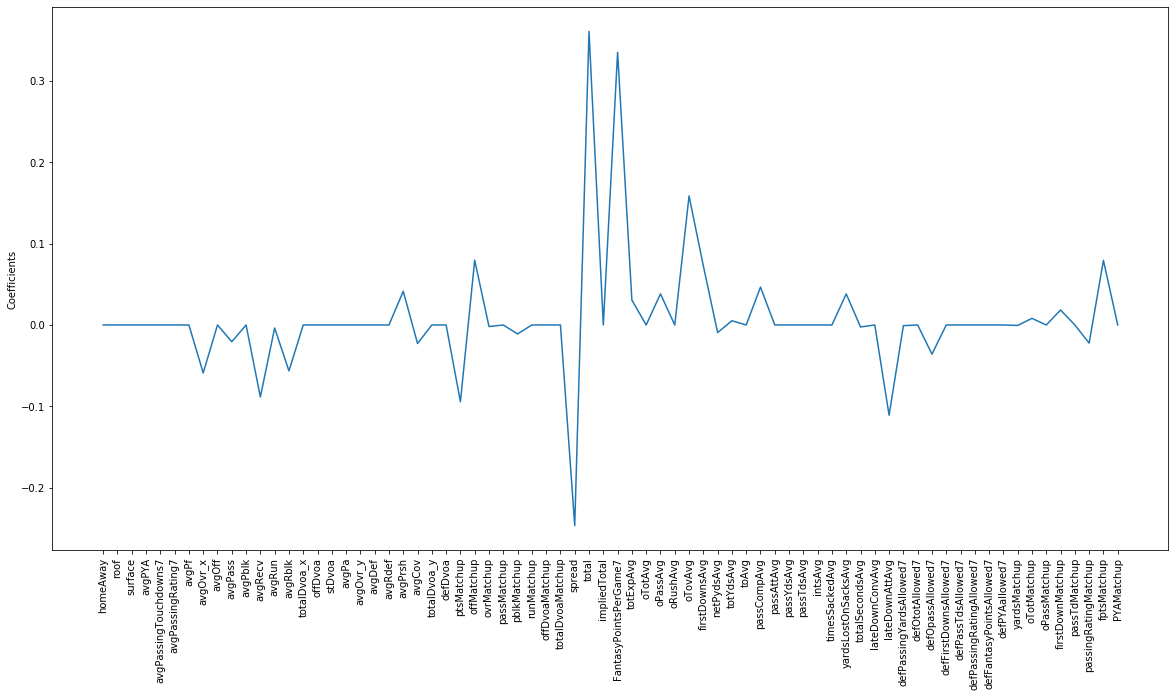

In [26]:
lasso = Lasso(alpha=0.1)
lasso_coef = lasso.fit(X_train,y_train).coef_

plt.figure(figsize=(20,10))
_ = plt.plot(range(len(X_train.columns)),lasso_coef)
_ = plt.xticks(range(len(X_train.columns)),X_train.columns, rotation=90)
_ = plt.ylabel('Coefficients')

plt.show()